# The (stochastic) Hodking-Huxley Model Neuron

We augment the deterministic description of neuronal excitability, based on the Hodgkin and Huxley model, with an **effective** description of ion-channel flickering. This makes possible to display and explore non-deterministic responses and a series of other phenomena arising from the *channel-noise*.

While the kinetic description for $n$, $m$, and $h$ remain the same, the charge balance equation is modified as it follows:

$$ C \frac{dV(t)}{dt}\ = \ G_{leak} (E_{leak} - V) + G_{Na} (m^3 h + \xi) (E_{Na} - V) + G_{K} (n^4 + \eta) (E_{K} - V) + I\\ $$

$\xi$ and $\eta$ are realisations of appropriate *stochastic processes*, capable of capturing (with **reduced computational load**) the random opening and closing of individual ion channels and its inherent voltage-dependence.

We explore interactively what happens to the membrane potential for increasing values of the external current $I$ and how the model respond to a square current pulse.

In [31]:
# @title Langevin's approach to channel noise (see Linaro et al., PLoS Comp Bio. 2011)

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

T      = 300.    # Maximal lifetime of the simulation [ms]
Δt     = 0.01    # Integration time step [ms] - WATCH OUT! DO NOT INCREASE!

C      = 0.010   # This is the membrane (specific) capacitance [uF/mm^2]
gnamax = 1.2     # Max (specific) sodium conductance [mS/mm^2]
gkmax  = 0.36    # Max (specific) potassium conductance [mS/mm^2]
gl     = 0.003   # Max (specific) leak conductance [mS/mm^2]

gamma_na = 10     # (pS) single chan. Na conductance
gamma_k  = 10     # (pS) single chan. K conductance

Nna    = 1000     # Number of voltage-gated sodium ionic channels
Nk     = 1000     # Number of voltage-gated potassium ionic channels

Ena    = 50.     # Reversal potential for sodium currents [mV]
Ek     = -77.    # Reversal potential for potassium currents [mV]
El     = -54.387 # Reversal potential for leak currents [mV]

time = np.linspace(0, T, int(T/Δt))  # Array containg the "time" axis [ms]
N    = len(time)                     # Length of "time", i.e. how many discrete time steps


def rates(V):
  αm = 0.1 * (V+40.) / (1. - np.exp(-(V+40.)/10.))
  βm  = 4. * np.exp(-0.0556 * (V+65))
  m_inf = αm / (αm + βm)
  τm = 1. / (αm + βm)
  m3_inf = m_inf ** 3
  one_minus_m_inf = 1. - m_inf

  αh = 0.07 * np.exp(-0.05*(V+65.))
  βh = 1. / (1. + np.exp(-0.1*(V+35.)))
  h_inf = αh / (αh + βh)
  τh = 1. / (αh + βh)
  one_minus_h_inf = 1. - h_inf

  τz1 = τh
  τz2 = τm
  τz3 = τm / 2
  τz4 = τm / 3
  τz5 = τm * τh / (τm + τh)
  τz6 = τm * τh / (τm + 2 * τh)
  τz7 = τm * τh / (τm + 3 * τh)

  var_z1 = 1.0 / Nna * m3_inf * m3_inf * h_inf * one_minus_h_inf
  var_z2 = 3.0 / Nna * m3_inf * m_inf  * m_inf * h_inf * h_inf * one_minus_m_inf
  var_z3 = 3.0 / Nna * m3_inf * m_inf  * h_inf * h_inf * one_minus_m_inf * one_minus_m_inf
  var_z4 = 1.0 / Nna * m3_inf * h_inf  * h_inf * one_minus_m_inf * one_minus_m_inf * one_minus_m_inf
  var_z5 = 3.0 / Nna * m3_inf * m_inf  * m_inf * h_inf * one_minus_m_inf * one_minus_h_inf
  var_z6 = 3.0 / Nna * m3_inf * m_inf  * h_inf * one_minus_m_inf * one_minus_m_inf * one_minus_h_inf
  var_z7 = 1.0 / Nna * m3_inf * h_inf  * one_minus_m_inf * one_minus_m_inf * one_minus_m_inf * one_minus_h_inf

  τz = (var_z1 + var_z2 + var_z3 + var_z4 + var_z5 + var_z6 + var_z7) / (var_z1 / τz1 + var_z2 / τz2 + var_z3 / τz3 + var_z4 / τz4 + var_z5 / τz5 + var_z6 / τz6 + var_z7 / τz7)
  var_z = 1.0 / Nna * m3_inf * h_inf * (1.0 - m3_inf * h_inf)

	# Exact
  μz = np.exp(-Δt/τz)
  noise_z = np.sqrt(var_z * (1-μz**2)) * np.random.normal()
  # Euler-Maruyama
  # noise_z = sqrt(2 * Δt * var_z / τz) * randn()

  αn = 0.01 * (V+55) / (1. - np.exp(-(V+55.)/10.))
  βn = 0.125 * np.exp(-(V+65.)/80.)
  n_inf = αn / (αn + βn)
  τn = 1. / (αn + βn)
  n4_inf = n_inf ** 4
  one_minus_n_inf = 1. - n_inf

  var_y1 = 4.0 / Nk * n4_inf * n_inf * n_inf * n_inf * one_minus_n_inf
  var_y2 = 6.0 / Nk * n4_inf * n_inf * n_inf * one_minus_n_inf * one_minus_n_inf
  var_y3 = 4.0 / Nk * n4_inf * n_inf * one_minus_n_inf * one_minus_n_inf * one_minus_n_inf
  var_y4 = 1.0 / Nk * n4_inf * one_minus_n_inf * one_minus_n_inf * one_minus_n_inf * one_minus_n_inf

  τy = (var_y1 + var_y2 + var_y3 + var_y4) / (var_y1 / τn + var_y2 / τn / 2 + var_y3 / τn/3 + var_y4/τn/4)
  var_y = 1.0 / Nk * n4_inf * (1.0 - n4_inf)

	# Exact
  μy = np.exp(-Δt/τy)
  noise_y = np.sqrt(var_y * (1-μy*μy)) * np.random.normal()
  # Euler-Maruyama
  #noise_y = sqrt(2 * Δt * var_y / τy) * randn()

  return αm, βm, αn, βn, αh, βh, μy, noise_y, μz, noise_z



def HH(I):
  W    = np.zeros(N)  # Array containing V as the time goes by
  Nspikes = 0           # Counter for the number of spikes

  # Initial conditions:
  V      = El
  yy     = 0.
  zz     = 0.
  αm, βm, αn, βn, αh, βh, _, _, _, _ = rates(V)

  m      = αm / (αm + βm)
  h      = αh / (αh + βh)
  n      = αn / (αn + βn)

  tmp    = 0        # For the peak detection

  # Euler method ---------------------------------------------------------------
  for k in range(N): # Loop over each discrete step for time t
    # Kinetic rates are expressed in msec
    αm, βm, αn, βn, αh, βh, μy, noise_y, μz, noise_z = rates(V)

    n     = n + Δt * (αn * (1-n) - βn * n)     # Euler forward method
    m     = m + Δt * (αm * (1-m) - βm * m)     # Euler forward method
    h     = h + Δt * (αh * (1-h) - βh * h)     # Euler forward method

    m = 1 if (m > 1) else m
    m = 0 if (m < 0) else m
    h = 1 if (h > 1) else h
    h = 0 if (h < 0) else h
    n = 1 if (n > 1) else n
    n = 0 if (n < 0) else n

    if noiseON:
		  # Exact
      yy    = yy * μy + noise_y
      zz    = zz * μz + noise_z

	    # Euler-Maruyama
	    #yy = yy - dt * yy / tau_y + noise_y
 	    #zz = zz - dt * zz / tau_z + noise_z
    else:
      yy = 0
      zz = 0

    GNA = gnamax * (m**3 * h + zz)
    GK  = gkmax  * (n**4 + yy)
    GNA = 0 if (GNA < 0) else GNA
    GK  = 0 if (GK < 0) else GK

    Ina   = GNA * (Ena - V)    # By definition
    Ik    = GK  * (Ek - V)	    # By definition
    Ileak = gl  * (El - V)		# By definition

    V     = V + Δt/C * (Ina + Ik + Ileak + I[k])  # Euler forward method

    W[k]  = V # Let's write the current V inside a new element of W[]
    if (tmp==0) and (V>-10):     # Detection of a "peak", with positive derivative
      tmp = 1
      Nspikes = Nspikes + 1
    elif (tmp==1) and (V<-10):  # if negative derivative, ignore it
      tmp = 0
  # ----------------------------------------------------------------------------

  freq = np.round(1000. * Nspikes / T)

  return W, freq

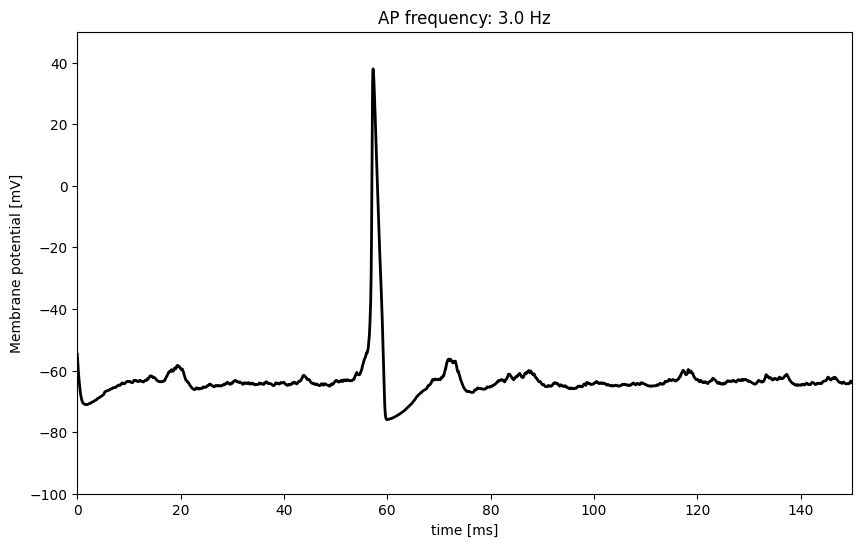

In [117]:
# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

noiseON = True # @param {type:"boolean"}

I = 0.014 #@param {type:"slider", min:-0.2, max:2, step:0.0005}
Nna    = 3910 # @param {type:"slider", min:10, max:100000, step:100}
Nk     = 4410 # @param {type:"slider", min:10, max:100000, step:100}

# Let's initialize with an array full of "1"
Istim = I * np.ones(N)

W, freq = HH(Istim)

mystr = f"AP frequency: {freq} Hz"

# Plotting instructions ------------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(time, W, color = 'black', linewidth = 2)
plt.xlim((0, 150))
plt.ylim((-100,50))
plt.xlabel("time [ms]")
plt.ylabel("Membrane potential [mV]")
plt.title(mystr)
plt.show()

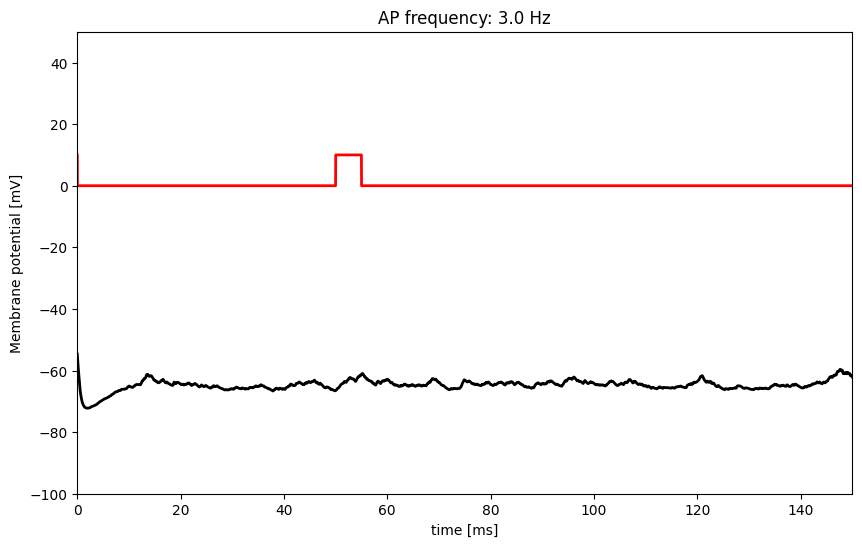

In [121]:
 # @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

noiseON = True # @param {type:"boolean"}

I = 0.0185 #@param {type:"slider", min:-0, max:0.03, step:0.0005}
Nna    = 4000 # @param {type:"slider", min:10, max:100000, step:100}
Nk     = 4000 # @param {type:"slider", min:10, max:100000, step:100}

# Let's initialize with an array full of "1"
Istim2 = I * np.ones(N)
Istim2[1:5000] = 0.
Istim2[5500:] = 0.

W2, freq2 = HH(Istim2)

mystr = f"AP frequency: {freq} Hz"

# Plotting instructions ------------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(time, W2, color = 'black', linewidth = 2)
plt.plot(time, 10*Istim2/I, color = 'red', linewidth = 2)
plt.xlim((0, 150))
plt.ylim((-100,50))
plt.xlabel("time [ms]")
plt.ylabel("Membrane potential [mV]")
plt.title(mystr)
plt.show()